<center> <h2> Doc2vec : </h2> </center>

In [1]:
import os
import re
import string
import random
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
from sklearn.manifold import TSNE

In [2]:
path_root = 'for_moodle/'

path_to_data = path_root + 'data/'
path_to_documents = path_root + 'data/documents/'
path_to_plots = path_root
path_to_google_news = path_root


In [3]:
# remove dashes and apostrophes from punctuation marks 
punct = string.punctuation.replace('-', '').replace("'",'')
# regex to match intra-word dashes and intra-word apostrophes
my_regex = re.compile(r"(\b[-']\b)|[\W_]")

In [4]:
# ========== functions ==========

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

def clean_string(string, punct=punct, my_regex=my_regex, to_lower=False):
    if to_lower:
        string = string.lower()
    # remove formatting
    str = re.sub('\s+', ' ', string)
     # remove punctuation
    str = ''.join(l for l in str if l not in punct)
    # remove dashes that are not intra-word
    str = my_regex.sub(lambda x: (x.group(1) if x.group(1) else ' '), str)
    # strip extra white space
    str = re.sub(' +',' ',str)
    # strip leading and trailing white space
    str = str.strip()
    return str

In [5]:
# read documents and labels
doc_names = os.listdir(path_to_documents)
doc_names.sort(key=natural_keys)
docs = []

for idx,name in enumerate(doc_names):
    with open(path_to_documents + name,'r') as my_file:
        docs.append(my_file.read())
    if idx % round(len(doc_names)/10) == 0:
        print(idx)

with open(path_to_data + 'labels.txt', 'r') as my_file: 
    labels = my_file.read().splitlines()

labels = np.array([int(item) for item in labels])

with open(path_to_data + 'smart_stopwords.txt', 'r') as my_file: 
    stpwds = my_file.read().splitlines()

0
1131
2262
3393
4524
5655
6786
7917
9048
10179
11310


In [6]:
shuffled_idxs = random.sample(range(len(docs)), len(docs)) # sample w/o replct
docs = [docs[idx] for idx in shuffled_idxs]
labels = [labels[idx] for idx in shuffled_idxs]

In [7]:
cleaned_docs = []
for idx, doc in enumerate(docs):
    # clean
    doc = clean_string(doc, punct, my_regex, to_lower=True)
    # tokenize (split based on whitespace)
    tokens = doc.split(' ')
    # remove stopwords
    tokens = [token for token in tokens if token not in stpwds]
    # remove digits
    tokens = [''.join([elt for elt in token if not elt.isdigit()]) for token in tokens]
    # remove tokens shorter than 3 characters in size
    tokens = [token for token in tokens if len(token)>2]
    # remove tokens exceeding 25 characters in size
    tokens = [token for token in tokens if len(token)<=25]
    cleaned_docs.append(tokens)
    if idx % round(len(docs)/10) == 0:
        print(idx)

0
1131
2262
3393
4524
5655
6786
7917
9048
10179
11310


In [8]:
n_left_out = 500 # docs used for testing

d2v_training_data = []

for idx,doc in enumerate(cleaned_docs[:-n_left_out]):
    ## add the documents using TaggedDocument
    d2v_training_data.append(TaggedDocument(words=doc, tags=[idx]))
    
    if idx % round(len(cleaned_docs)/10) == 0:
        print(idx)

labels_training = labels[:-n_left_out]

0
1131
2262
3393
4524
5655
6786
7917
9048
10179


In [9]:
# ========== learning doc embeddings with doc2vec ==========

# PV stands for 'Paragraph Vector'
# PV-DM (distributed memory) dm=1 (gensim's default)
# PV-DBOW (distributed bag-of-words)

my_p = 50

d2v_dm = Doc2Vec(d2v_training_data, 
                 vector_size=my_p,
                 epochs=20,
                 window=4, 
                 min_count=3, 
                 workers=4)

d2v_dm.delete_temporary_training_data(keep_doctags_vectors=True, 
                                      keep_inference=True)

d2v_dm_vecs = np.array(d2v_dm.docvecs.vectors_docs)

d2v_vecs = d2v_dm_vecs

In [10]:
# visualize document embeddings
n_plot = 1000

my_pca = PCA(n_components=10)
my_tsne = TSNE(n_components=2)
d2v_vecs_pca = my_pca.fit_transform(d2v_vecs[:n_plot,]) 

d2v_vecs_tsne = my_tsne.fit_transform(d2v_vecs_pca)

labels_plt = list(labels_training[:n_plot])

/home/rostom/.local/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


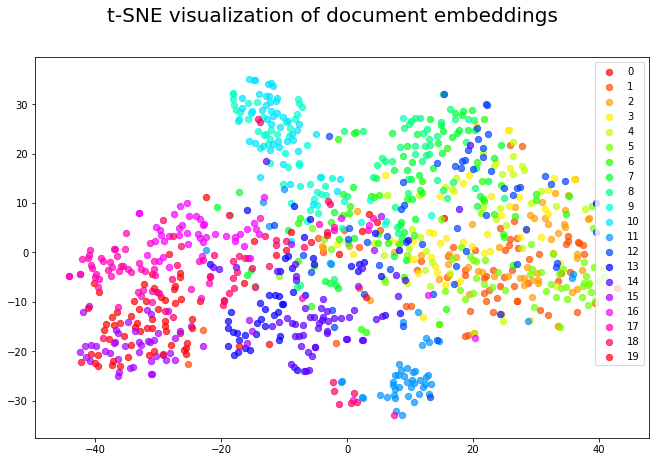

In [11]:
my_colors = ['blue',
             'red',
             'red',
             'red',
             'red',
             'red',
             'green',
             'orange',
             'orange',
             'orange',
             'orange',
             'yellow',
             'yellow',
             'yellow',
             'yellow',
             'pink',
             'brown',
             'brown',
             'brown',
             'brown']

palette = plt.get_cmap('hsv',len(list(set(labels_plt))))
fig, ax = plt.subplots()

for label in list(set(labels_plt)):
    idxs = [idx for idx,elt in enumerate(labels_plt) if elt==label]
    ## fill the gaps ## plot the points
    ax.scatter(d2v_vecs_tsne[idxs,0],
               d2v_vecs_tsne[idxs,1],
               c = rgb2hex(palette(label)),
               #c = my_colors[label],
               label=str(label),
               alpha=0.7,
               s=40)

ax.legend(scatterpoints=1)
fig.suptitle('t-SNE visualization of document embeddings',fontsize=20)
fig.set_size_inches(11,7)
fig.savefig(path_to_plots + 'doc_embeddings.png',dpi=300)
fig.show()

In [13]:
# ========== using doc2vec embeddings for classification ==========

classifier = LinearSVC()
classifier.fit(d2v_vecs, labels_training)

# get paragraph vectors of documents in the test set
d2v_vecs_test = np.empty(shape=(n_left_out, my_p))

for idx,doc in enumerate(cleaned_docs[-n_left_out:]):
    # use d2v_dm.infer_vector and ...
    to_add = d2v_dm.infer_vector(doc)
    d2v_vecs_test[idx,:] = to_add
    if idx % round(n_left_out/10) == 0:
        print(idx)

preds = classifier.predict(d2v_vecs_test)

print('accuracy of SVM with doc2vec features:',round(accuracy_score(labels[-n_left_out:],preds)*100,2))

# comparing with TFIDF baseline
classifier_tfidf = LinearSVC()

tfidf_vect = TfidfVectorizer(min_df=3, 
                             stop_words=None, 
                             lowercase=False, 
                             preprocessor=None)

# tfidf_vectorizer takes raw documents as input
doc_term_mtx = tfidf_vect.fit_transform([' '.join(elt) for elt in cleaned_docs[:-n_left_out]])

classifier_tfidf.fit(doc_term_mtx, labels_training)

# get TFIDF representations of the test set docs
doc_term_mtx_test = tfidf_vect.transform([' '.join(elt) for elt in cleaned_docs[-n_left_out:]])

preds_tfidf = classifier_tfidf.predict(doc_term_mtx_test)

print('accuracy of SVM with TFIDF features:',round(accuracy_score(labels[-n_left_out:],preds_tfidf)*100,2))


/home/rostom/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0
50
100
150
200
250
300
350
400
450
accuracy of SVM with doc2vec features: 64.4
accuracy of SVM with TFIDF features: 92.8
